In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report, roc_curve, auc)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

In [3]:
file_path = "/content/loan_prediction.csv"
df = pd.read_csv(file_path)
print("Shape:", df.shape)
display(df.head())

Shape: (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
print("\nColumns and types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())
print("\nValue counts of target (Loan_Status):\n", df['Loan_Status'].value_counts(dropna=False))


Columns and types:
 Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

Missing values:
 Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Value counts of target (Loan_Status):
 Loan_Status
Y    422
N    192
Name: count, dtype: int64


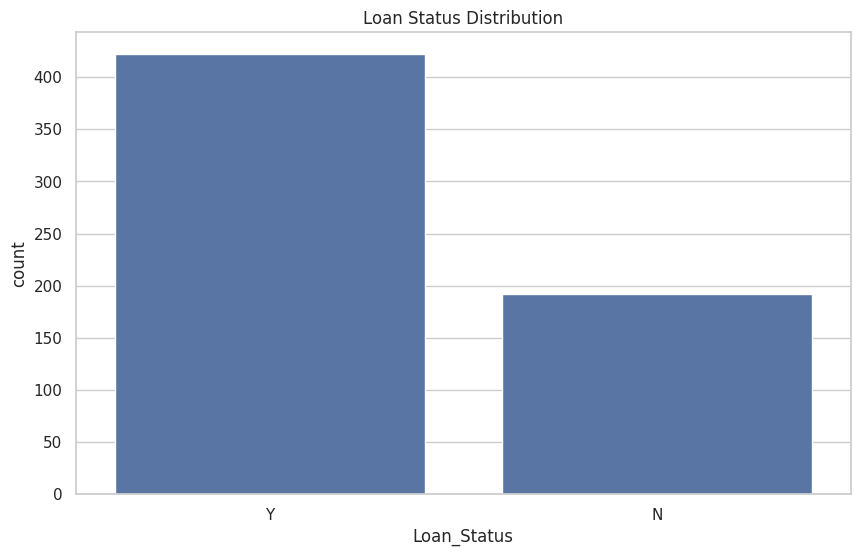

In [7]:
# 4) Basic EDA / Visualizations
# Target distribution
plt.figure()
sns.countplot(x='Loan_Status', data=df)
plt.title("Loan Status Distribution")
plt.show()

Numerical columns: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


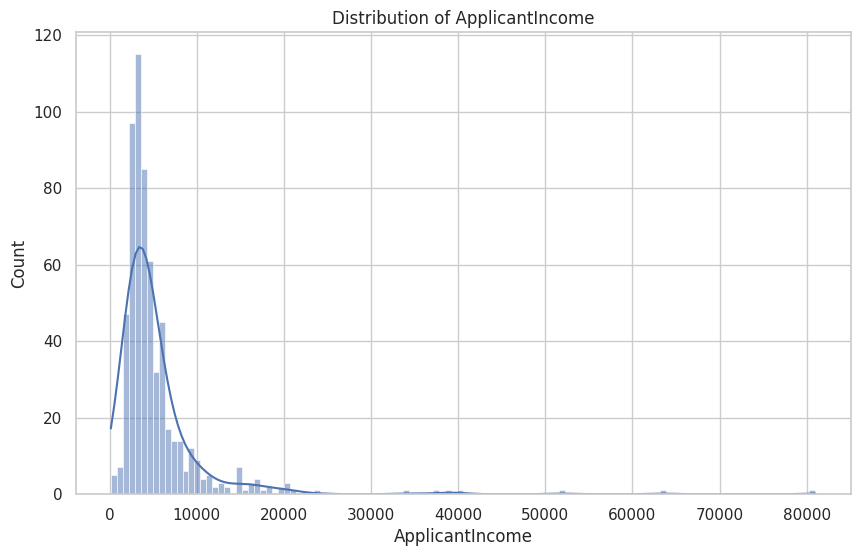

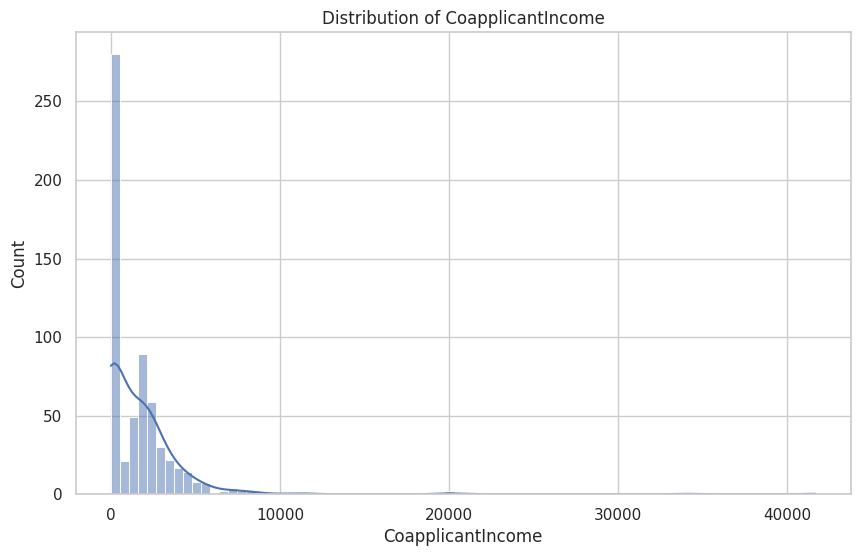

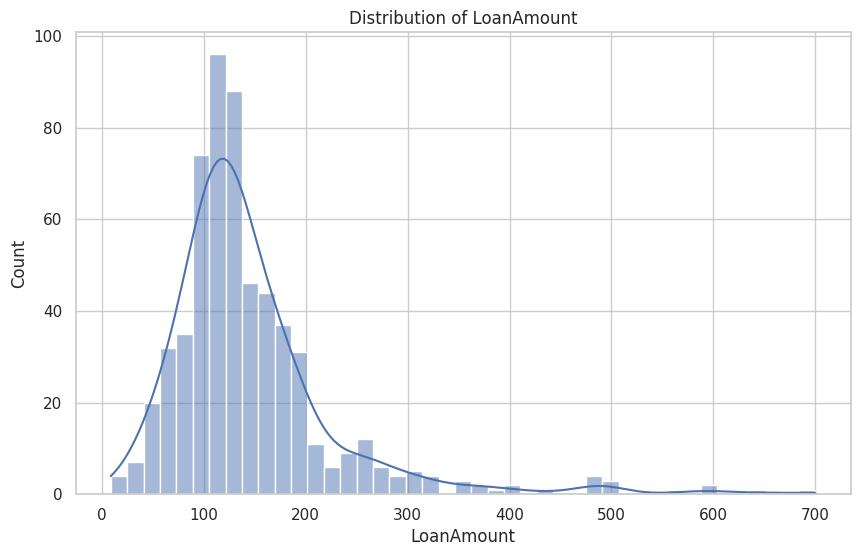

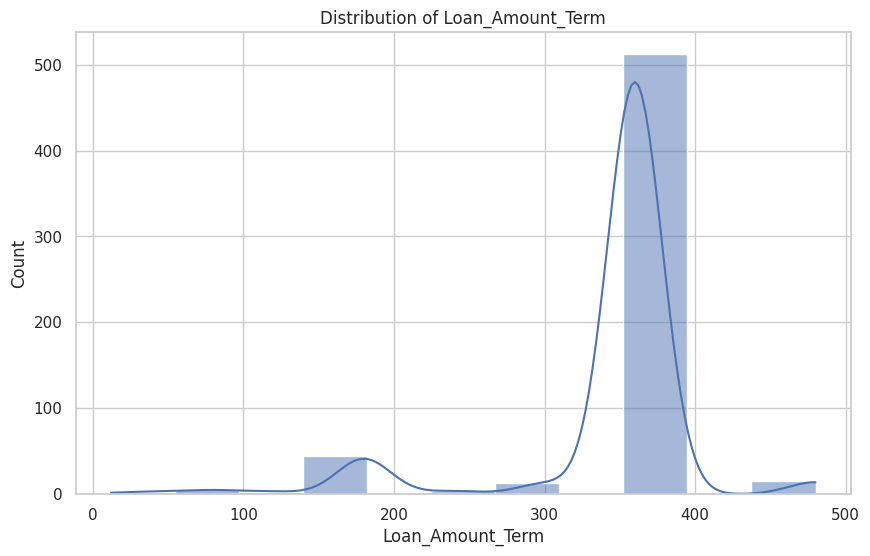

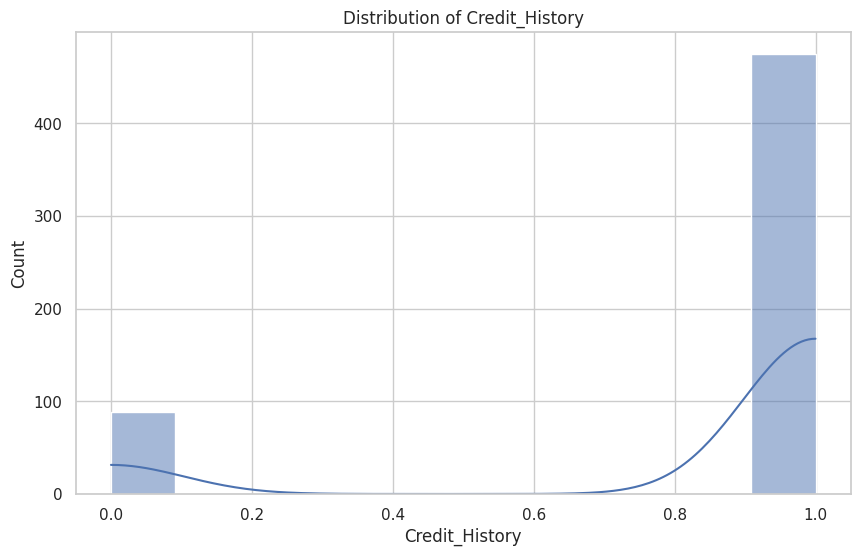

In [8]:
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
print("Numerical columns:", num_cols)
for col in num_cols:
    plt.figure()
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

Categorical columns: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']


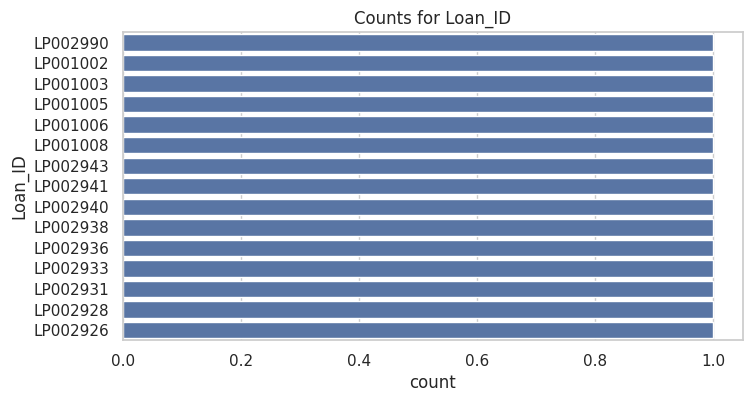

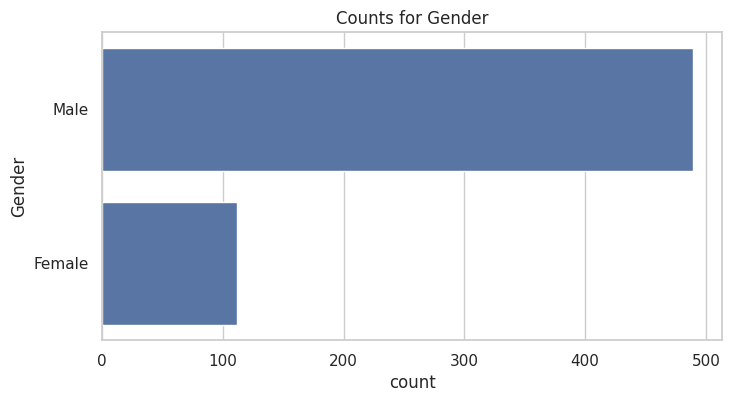

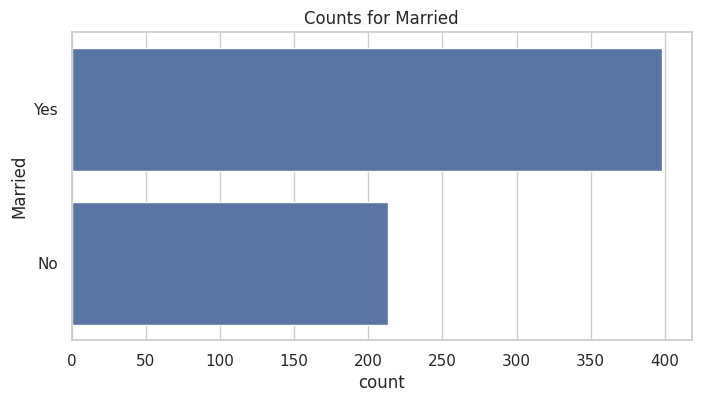

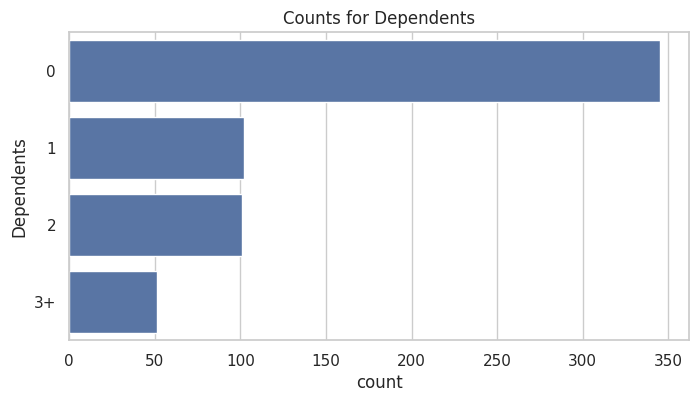

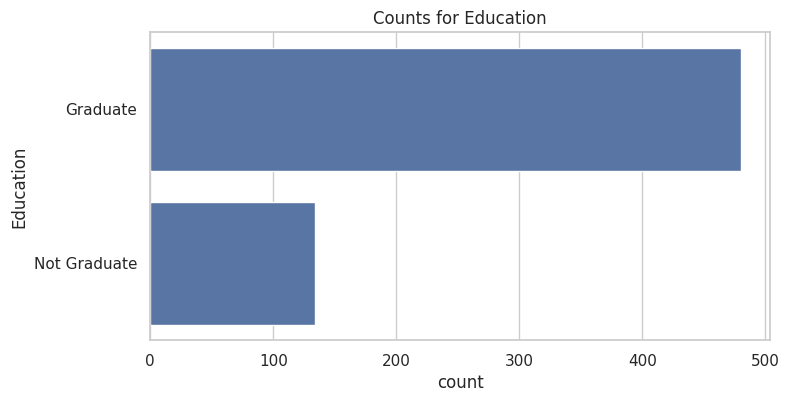

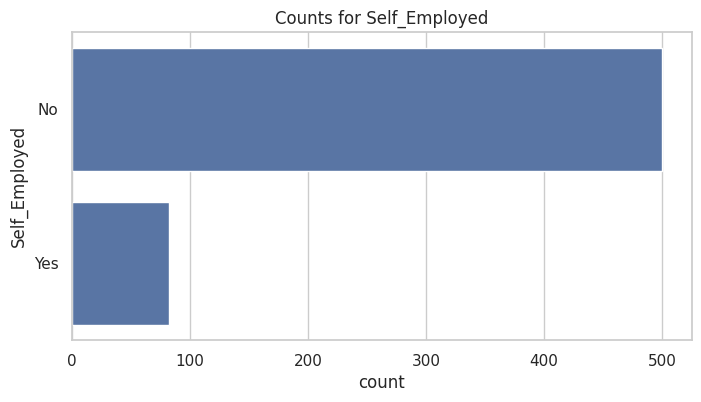

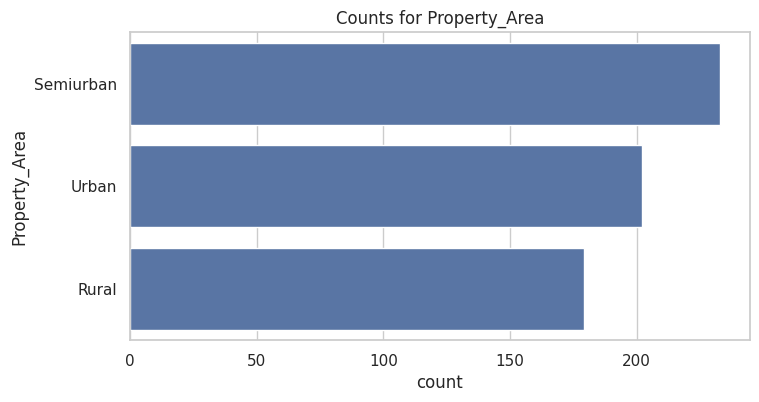

In [9]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", cat_cols)
for col in cat_cols:
    if col == 'Loan_Status':
        continue
    plt.figure(figsize=(8,4))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index[:15])
    plt.title(f"Counts for {col}")
    plt.show()

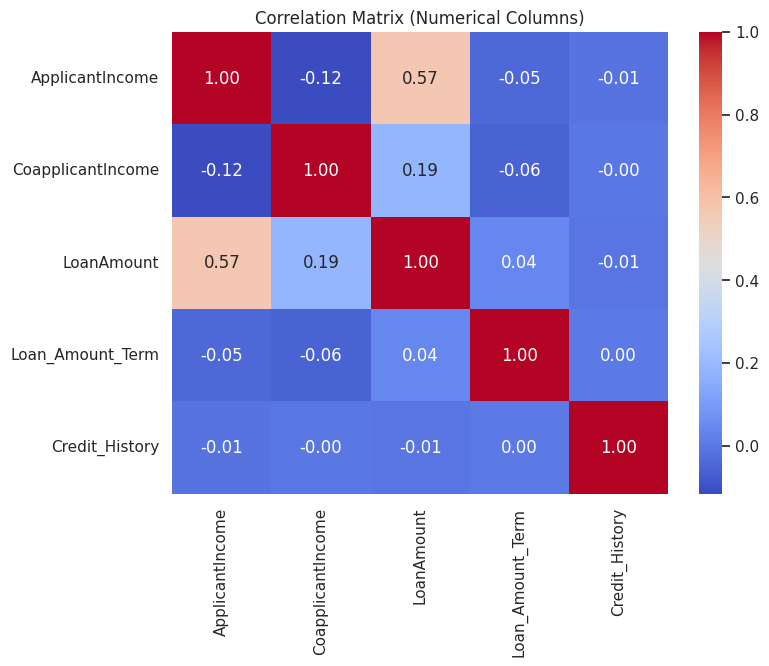

In [10]:
if len(num_cols) > 1:
    plt.figure(figsize=(8,6))
    sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
    plt.title("Correlation Matrix (Numerical Columns)")
    plt.show()

In [11]:
# 5) Data cleaning & preprocessing
# -- Standard steps (customize if your dataset differs) --

# Make a copy
data = df.copy()

# Normalize column names (optional)
data.columns = [c.strip() for c in data.columns]

# Identify features and target
target_col = 'Loan_Status'   # change if necessary
if target_col not in data.columns:
    raise ValueError(f"Target column '{target_col}' not found in dataset.")

X = data.drop(columns=[target_col])
y = data[target_col].map({'Y':1, 'N':0}) if set(data[target_col].dropna().unique()) <= {'Y','N'} else data[target_col]

# Distinguish numeric vs categorical
numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
Categorical features: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']


In [13]:
# Preprocessing pipeline:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [14]:
# 6) Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (491, 12) Test shape: (123, 12)


In [15]:
# 7) Build pipelines for models
# Logistic Regression pipeline
pipe_lr = Pipeline(steps=[('pre', preprocessor),
                          ('clf', LogisticRegression(max_iter=1000, random_state=42))])

# Random Forest pipeline
pipe_rf = Pipeline(steps=[('pre', preprocessor),
                          ('clf', RandomForestClassifier(n_estimators=100, random_state=42))])

# Fit baseline models
print("\nTraining Logistic Regression...")
pipe_lr.fit(X_train, y_train)
print("Training Random Forest...")
pipe_rf.fit(X_train, y_train)


Training Logistic Regression...
Training Random Forest...


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['ApplicantIncome',
                                                   'CoapplicantIncome',
                                                   'LoanAmount',
                                                   'Loan_Amount_Term',
                                                   'Credit_History']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Loan_ID', 'Gender',
                                                   'Married', 'Dependents',
                                                   'Education', 'Self_Employed',
                                                   'Property_Area'])])),
                ('clf', RandomForestClassifier(random_state=42))])


=== Logistic Regression Evaluation ===
Accuracy: 0.8618
Precision: 0.84
Recall: 0.9882
F1-score: 0.9081
ROC AUC: 0.8523

Classification Report:
               precision    recall  f1-score   support

           0     0.9565    0.5789    0.7213        38
           1     0.8400    0.9882    0.9081        85

    accuracy                         0.8618       123
   macro avg     0.8983    0.7836    0.8147       123
weighted avg     0.8760    0.8618    0.8504       123



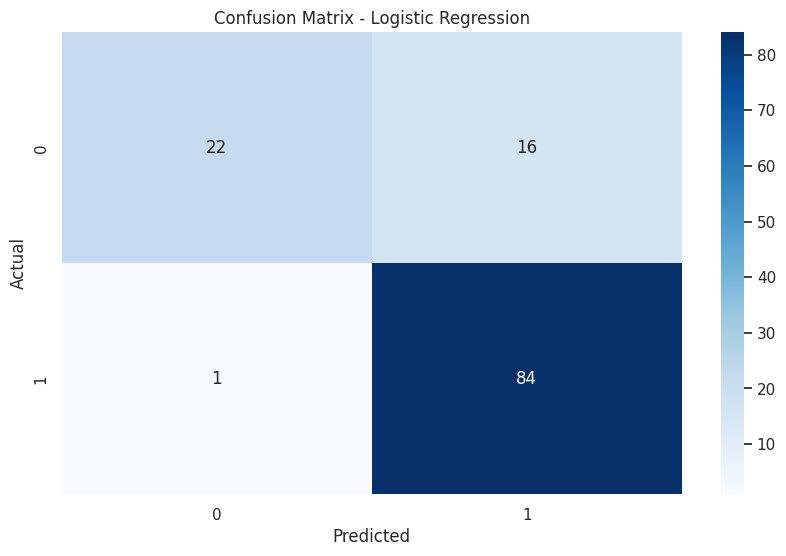

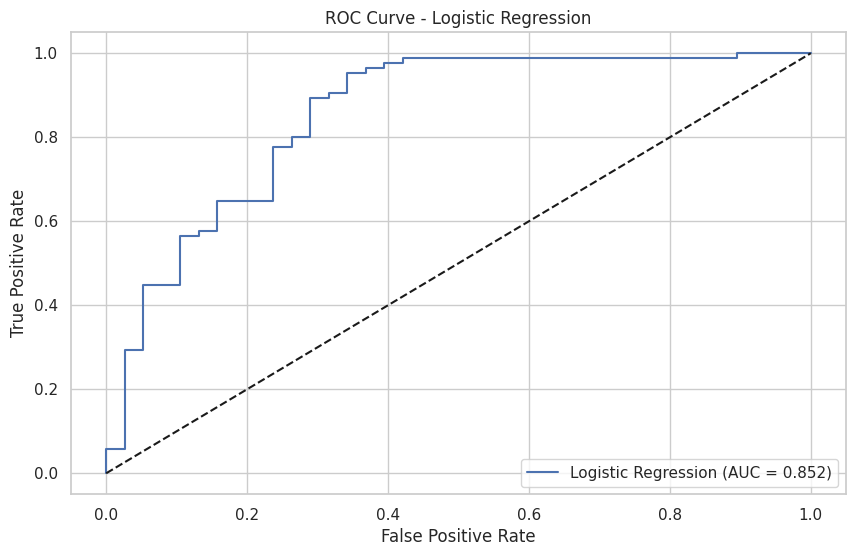


=== Random Forest Evaluation ===
Accuracy: 0.8455
Precision: 0.83
Recall: 0.9765
F1-score: 0.8973
ROC AUC: 0.8031

Classification Report:
               precision    recall  f1-score   support

           0     0.9130    0.5526    0.6885        38
           1     0.8300    0.9765    0.8973        85

    accuracy                         0.8455       123
   macro avg     0.8715    0.7646    0.7929       123
weighted avg     0.8557    0.8455    0.8328       123



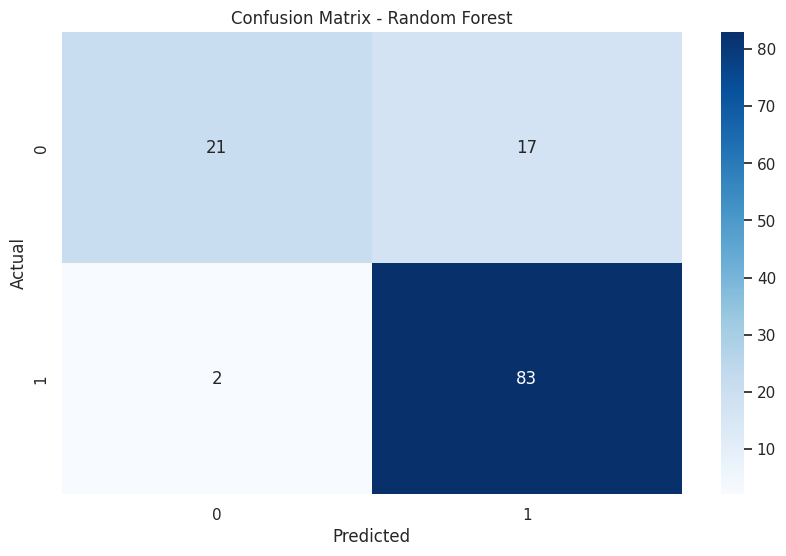

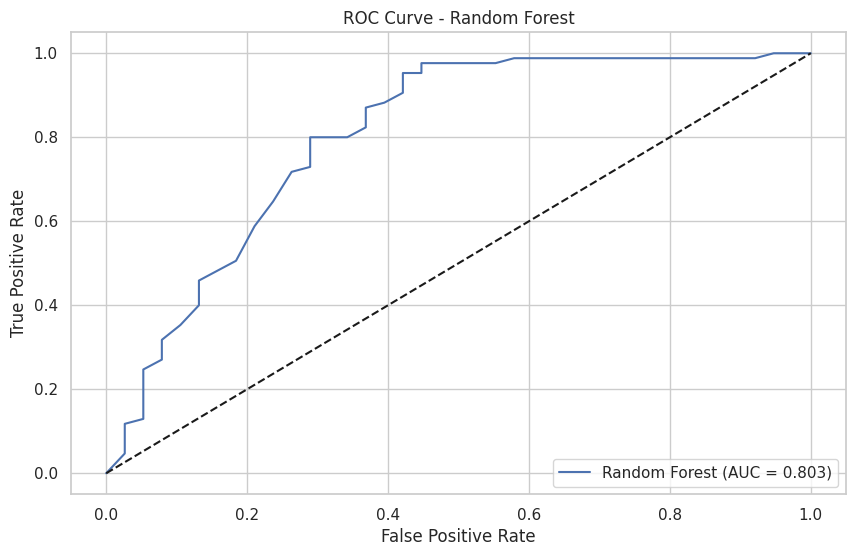

In [16]:
# 8) Evaluate models (function)
def evaluate_model(pipe, X_tr, y_tr, X_te, y_te, label="Model"):
    y_pred = pipe.predict(X_te)
    y_proba = pipe.predict_proba(X_te)[:,1] if hasattr(pipe, "predict_proba") else None
    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, zero_division=0)
    rec = recall_score(y_te, y_pred, zero_division=0)
    f1 = f1_score(y_te, y_pred, zero_division=0)
    roc = roc_auc_score(y_te, y_proba) if y_proba is not None else None
    print(f"\n=== {label} Evaluation ===")
    print("Accuracy:", round(acc,4))
    print("Precision:", round(prec,4))
    print("Recall:", round(rec,4))
    print("F1-score:", round(f1,4))
    if roc is not None:
        print("ROC AUC:", round(roc,4))
    print("\nClassification Report:\n", classification_report(y_te, y_pred, digits=4))
    cm = confusion_matrix(y_te, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {label}")
    plt.show()
    # ROC curve
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_te, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc:.3f})')
        plt.plot([0,1],[0,1],'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {label}")
        plt.legend(loc='lower right')
        plt.show()
    return {'accuracy':acc, 'precision':prec, 'recall':rec, 'f1':f1, 'roc_auc':roc}

# Evaluate baseline models
results_lr = evaluate_model(pipe_lr, X_train, y_train, X_test, y_test, label="Logistic Regression")
results_rf = evaluate_model(pipe_rf, X_train, y_train, X_test, y_test, label="Random Forest")

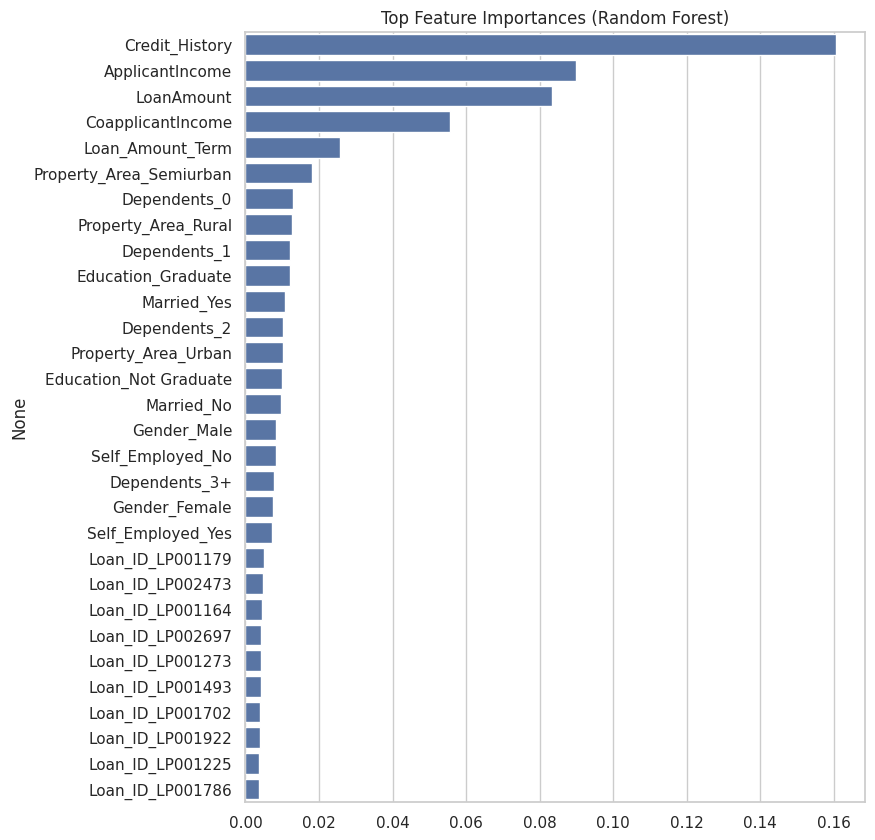

In [17]:
# 9) Feature importance (for Random Forest)
# We need to get transformed feature names from preprocessor's OneHotEncoder
def get_feature_names(preprocessor):
    feature_names = []
    # numeric
    if numeric_features:
        feature_names.extend(numeric_features)
    # categorical - from onehot
    try:
        ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
        cat_names = ohe.get_feature_names_out(categorical_features).tolist()
        feature_names.extend(cat_names)
    except Exception as e:
        # fallback: use categorical feature names as-is
        feature_names.extend(categorical_features)
    return feature_names

# Extract feature importances (RF)
try:
    rf_clf = pipe_rf.named_steps['clf']
    # get transformed X_train to align features
    X_train_trans = pipe_rf.named_steps['pre'].transform(X_train)
    feat_names = get_feature_names(pipe_rf.named_steps['pre'])
    importances = rf_clf.feature_importances_
    fi = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(30)
    plt.figure(figsize=(8,10))
    sns.barplot(x=fi.values, y=fi.index)
    plt.title("Top Feature Importances (Random Forest)")
    plt.show()
except Exception as e:
    print("Could not compute feature importances:", e)


Running GridSearchCV for Random Forest (this may take a while)...
Best params: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Best CV score: 0.8695946835109882

=== Tuned Random Forest Evaluation ===
Accuracy: 0.8455
Precision: 0.83
Recall: 0.9765
F1-score: 0.8973
ROC AUC: 0.7957

Classification Report:
               precision    recall  f1-score   support

           0     0.9130    0.5526    0.6885        38
           1     0.8300    0.9765    0.8973        85

    accuracy                         0.8455       123
   macro avg     0.8715    0.7646    0.7929       123
weighted avg     0.8557    0.8455    0.8328       123



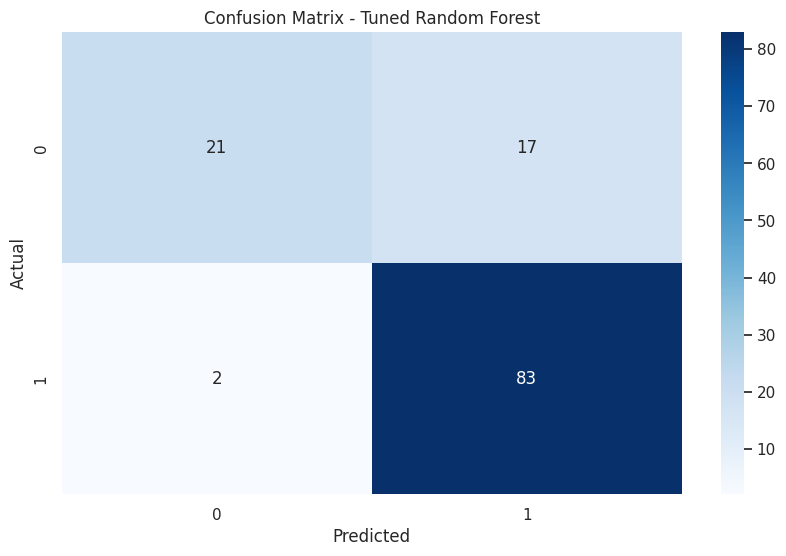

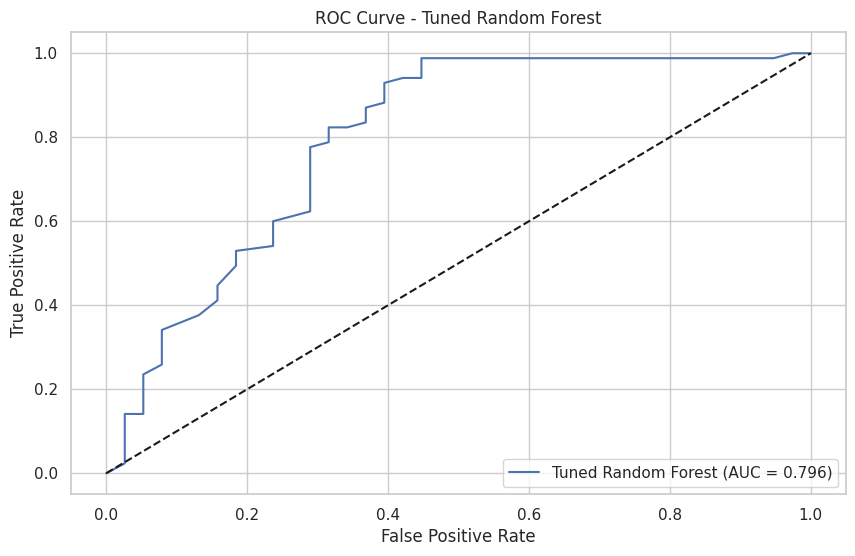

In [18]:
# 10) Hyperparameter tuning (Random Forest example)
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 6, 10],
    'clf__min_samples_split': [2, 5]
}
grid = GridSearchCV(pipe_rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
print("\nRunning GridSearchCV for Random Forest (this may take a while)...")
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

# Evaluate best estimator
best_rf = grid.best_estimator_
results_best_rf = evaluate_model(best_rf, X_train, y_train, X_test, y_test, label="Tuned Random Forest")


=== XGBoost Evaluation ===
Accuracy: 0.7886
Precision: 0.8391
Recall: 0.8588
F1-score: 0.8488
ROC AUC: 0.7703

Classification Report:
               precision    recall  f1-score   support

           0     0.6667    0.6316    0.6486        38
           1     0.8391    0.8588    0.8488        85

    accuracy                         0.7886       123
   macro avg     0.7529    0.7452    0.7487       123
weighted avg     0.7858    0.7886    0.7870       123



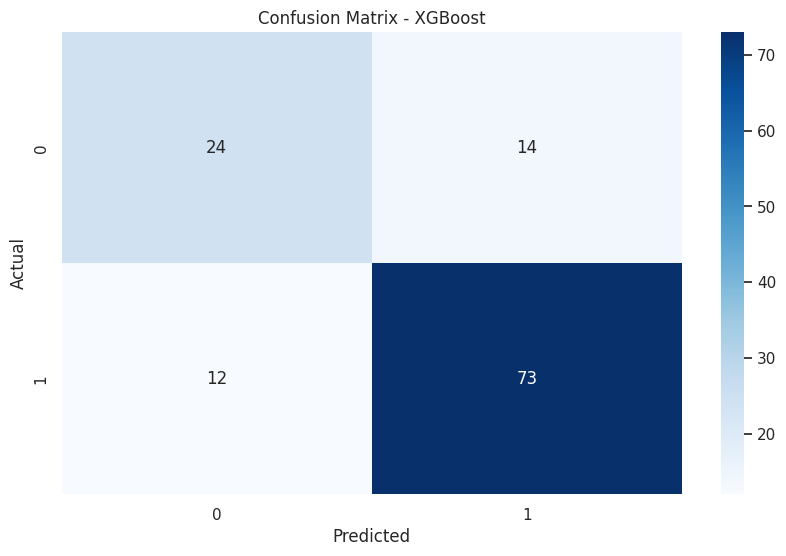

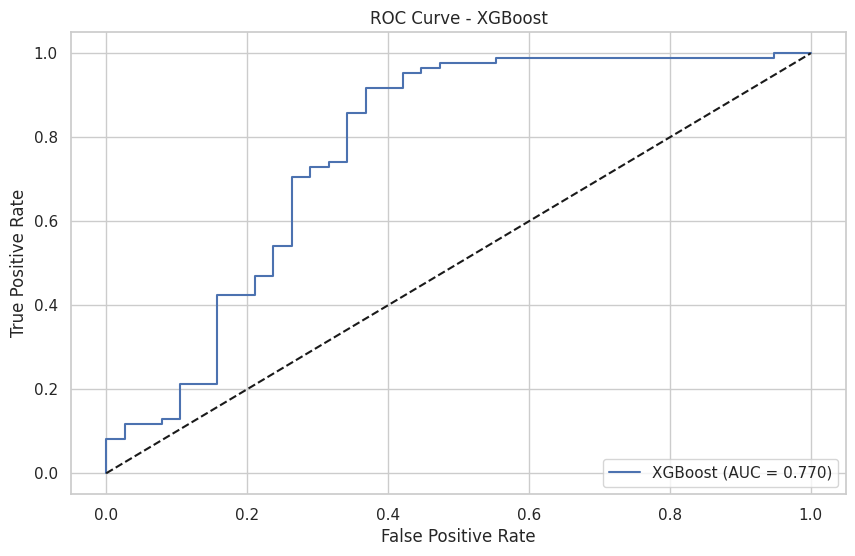

In [19]:
# 11) Optional: XGBoost (if installed)
try:
    from xgboost import XGBClassifier
    pipe_xgb = Pipeline(steps=[('pre', preprocessor),
                               ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))])
    pipe_xgb.fit(X_train, y_train)
    results_xgb = evaluate_model(pipe_xgb, X_train, y_train, X_test, y_test, label="XGBoost")
except Exception as e:
    print("XGBoost not available or failed to run. Skipping XGBoost step.")

In [20]:
# 12) Select best model and save it
# We'll choose best based on f1 or roc_auc (here using f1 on test)
models_results = {
    'LogisticRegression': results_lr['f1'],
    'RandomForest': results_rf['f1'],
    'TunedRandomForest': results_best_rf['f1']
}
print("\nF1 scores summary:", models_results)

# Choose best model object:
best_model = best_rf  # tuned RF from GridSearch (change if you want another)
joblib.dump(best_model, "best_loan_model.pkl")
print("Saved best model to best_loan_model.pkl")


F1 scores summary: {'LogisticRegression': 0.9081081081081082, 'RandomForest': 0.8972972972972973, 'TunedRandomForest': 0.8972972972972973}
Saved best model to best_loan_model.pkl


In [21]:
# 13) Create a sample prediction function
def predict_sample(sample_dict, model=best_model):
    # sample_dict should be a mapping {col: value}
    sample_df = pd.DataFrame([sample_dict])
    pred = model.predict(sample_df)[0]
    proba = model.predict_proba(sample_df)[0][1] if hasattr(model, "predict_proba") else None
    return {'prediction': int(pred), 'probability': float(proba) if proba is not None else None}

# Example usage (replace keys with your dataset's columns)
example = {}
for c in X.columns:
    # simple default example: use mode/median from training set
    if c in numeric_features:
        example[c] = X_train[c].median() if c in X_train else 0
    else:
        example[c] = X_train[c].mode()[0] if c in X_train else ''
print("Example sample prepared:", example)
print("Prediction for example:", predict_sample(example))

Example sample prepared: {'Loan_ID': 'LP001002', 'Gender': 'Male', 'Married': 'Yes', 'Dependents': '0', 'Education': 'Graduate', 'Self_Employed': 'No', 'ApplicantIncome': 3859.0, 'CoapplicantIncome': 1032.0, 'LoanAmount': 128.0, 'Loan_Amount_Term': 360.0, 'Credit_History': 1.0, 'Property_Area': 'Semiurban'}
Prediction for example: {'prediction': 1, 'probability': 0.995}


In [22]:
print("\nDone. Notebook performed EDA, trained baseline models, performed tuning for Random Forest,")
print("saved the best model to best_loan_model.pkl, and provided a sample prediction function.")
print("Next steps you can do: add cross-validation for all models, handle class imbalance (SMOTE),")
print("use feature selection, try LightGBM/XGBoost and more advanced hyperparameter tuning.")


Done. Notebook performed EDA, trained baseline models, performed tuning for Random Forest,
saved the best model to best_loan_model.pkl, and provided a sample prediction function.
Next steps you can do: add cross-validation for all models, handle class imbalance (SMOTE),
use feature selection, try LightGBM/XGBoost and more advanced hyperparameter tuning.
